# Image classification


In [ ]:
!pip install tensorflow
!apt-get -qq install -y graphviz && pip install pydot
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.

## Image separating and preprocessing

In [ ]:
import keras
from keras import layers
from keras import Sequential
import tensorflow
from pathlib import Path
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydot

In [ ]:
print(tensorflow.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [ ]:
!git clone https://github.com/marslayr/soil-imageclassifier.git

Cloning into 'soil-imageclassifier'...
remote: Enumerating objects: 1430, done.
remote: Total 1430 (delta 0), reused 0 (delta 0), pack-reused 1430 (from 1)
Receiving objects: 100% (1430/1430), 114.91 MiB | 72.14 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
# resize all images

batch_size = 128
image_size = (180, 180)
root_folder = Path("/content/soil-imageclassifier/data/soil-types/dataset")
image_files = [f for f in root_folder.glob("**/*") if f.suffix.lower() in [".jpg", ".png", ".jpeg"]]

resized_images = Path("/content/soil-imageclassifier/data/resized_images")
resized_images.mkdir(parents=True, exist_ok=True)

for img_path in image_files:
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Skipping unreadable file: {img_path}")
        continue

    resized_img = cv2.resize(img, (image_size[0], image_size[1]), interpolation=cv2.INTER_AREA)

    relative_path = img_path.relative_to(root_folder)  # Get relative path
    output_path = resized_images / relative_path  # Maintain subfolder structure
    output_path.parent.mkdir(parents=True, exist_ok=True)  # Create subfolders if needed

    cv2.imwrite(str(output_path), resized_img)

In [ ]:
# test if we got all the files

root_folder = Path("/content/soil-imageclassifier/data/resized_images")

image_files = [f for f in root_folder.glob("**/*") if f.suffix.lower() in [".jpg", ".png", ".jpeg"]]

for img_path in image_files:
    img = cv2.imread(str(img_path))  # Load image
    if img is None:
        print(f"Could not read: {img_path}")
        continue

    h, w = img.shape[:2]  # Get height & width
    if h != 180:
        print(f"{img_path} → {w}x{h}")

print(len(image_files))

1555


In [ ]:
train_dir = "/content/soil-imageclassifier/data/resized_images/train"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(180, 180),  # Resize images (change if needed)
    validation_split=0.01,  # 20% for validation
    batch_size=128,         # Define batch size
    subset="training",      # Specify the subset
    shuffle=True,           # Shuffle data
    seed=1337                 # Set random seed for reproducibility
)

for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Found 1215 files belonging to 4 classes.
Using 1203 files for training.
Batch shape: (128, 180, 180, 3), Labels shape: (128,)


In [ ]:
test_dir = "/content/soil-imageclassifier/data/resized_images/test"

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    subset="validation",
    validation_split=0.99,
    image_size=(180, 180),
    batch_size=128,
    shuffle=True,
    seed=1337,
)


for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")


Found 340 files belonging to 4 classes.
Using 336 files for validation.
Batch shape: (128, 180, 180, 3), Labels shape: (128,)


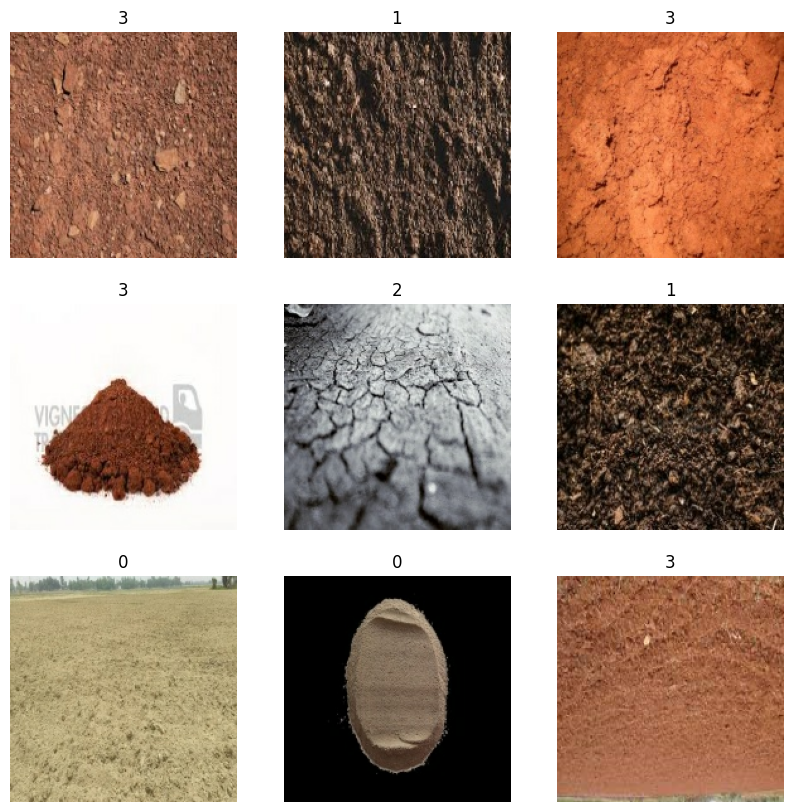

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
# data augmentation, adds random errors to the data
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



# Building a model

### A simple sequential CNN

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Xception

Takes a long amount of time to train with my hardware.

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


NameError: name 'image_size' is not defined

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)